# Рекомендация тарифов оператора мобильной связи

## Оглавление
* [Подготовка к работе](#по_кр)
* [Открытие, изучение и подготовка данных](#от_из)
* [Исследование моделей](#ис_мо)
    * [Выбор метрики](#вы_ме)
    * [LogisiticRegression](#ло_ре)
    * [RandomForestClassifier](#ра_фо)
    * [DummyClassifier](#да_кл)
    * [Тестирование лучшей модели](#те_лу)
* [Выводы](#вы)

## Подготовка к работе <a class="anchor" id="по_кр"></a>

Импортируем нужные библиотеки, зададим значения параметров и опишем функции.

In [1]:
import time
from tqdm import tqdm  
from time import sleep
from IPython.display import Markdown, display 
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 567

In [2]:
size_small = 10
size_medium = 12

plt.rc('font', size=size_small)
plt.rc('axes', titlesize=size_medium)
plt.rc('axes', labelsize=size_small)
plt.rc('xtick', labelsize=size_small)
plt.rc('ytick', labelsize=size_small)
plt.rc('legend', fontsize=size_small)

In [3]:
# фунция для обучения модели с заданными гиперпараметрами, получения предсказаний 
# и сохранения результатов в датафрейм

def fit_result(model, params, X_train, y_train, X_val, y_val):
    start = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start
    
    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_val)
    
    f1_train = f1_score(y_train, predictions_train)
    f1_val = f1_score(y_val, predictions_val)
    
    accumulator = {params[0]:globals()[params[0]],
                   params[1]:globals()[params[1]],
                   'f1_train':f1_train,
                   'f1_val':f1_val,
                   'fit_time':fit_time}
    accumulator_df = pd.DataFrame(accumulator, index=[0])
        
    return accumulator_df

In [4]:
# функция для отображения графиков зависимости метрики и времени обучения от гиперпараметров

def pair_plot(data, p1, p2):
    fig, ax = plt.subplots(3, 2, figsize=(12,10))
    plt.subplots_adjust(wspace=0.2, hspace=0.4)

    sns.pointplot(x=p1, y='f1_train', hue=p2, data=data, palette='colorblind', linewidth=1, ax=ax[0,0])
    ax[0, 0].grid(True, linestyle='--')

    sns.pointplot(x=p1, y='f1_val', hue=p2, data=data, palette='colorblind', linewidth=1,  ax=ax[0, 1])
    ax[0, 1].grid(True, linestyle='--')

    sns.pointplot(x=p2, y='f1_train', hue=p1, data=data, palette='colorblind', linewidth=1, ax=ax[1, 0])
    ax[1, 0].grid(True, linestyle='--')

    sns.pointplot(x=p2, y='f1_val', hue=p1, data=data, palette='colorblind', linewidth=1, ax=ax[1, 1])
    ax[1, 1].grid(True, linestyle='--')

    sns.lineplot(x=p2, y='f1_train', data=data, color='g', label='f1_train', ax=ax[2, 0]);
    sns.lineplot(x=p2, y='f1_val', data=data, color='r', label='f1_val', ax=ax[2, 0]);
    ax[2, 0].grid(True, linestyle='--')

    sns.pointplot(x=p2, y='fit_time', hue=p1, data=data, palette='colorblind', linewidth=1, ax=ax[2, 1])    
    ax[2, 1].grid(True, linestyle='--')
    
    plt.show()

    display(Markdown('**Наилучший набор гиперпараметров:**'))
    display(data[data['f1_val'] == max(data['f1_val'])].sort_values(by='fit_time', ascending=False).head(1))

In [5]:
# функция для отображения коэффициентов модели

def show_coef(names, coef):
    plt.figure(figsize=(10,len(names)))
    sbp = sns.barplot(y=names, x=abs(coef), orient='h', palette="husl");
    bar_values = [rect.get_width() for rect in sbp.patches]
    
    for rect, value in zip(sbp.patches, bar_values):
        if value > max(bar_values)*.8:
            sbp.annotate(f"{value:.5f}", (value, rect.get_y() + rect.get_height() / 2),
                     xytext=(-10, 0), textcoords='offset points', ha='right', va='center')
        else:
            sbp.annotate(f"{value:.5f}", (value, rect.get_y() + rect.get_height() / 2),
                     xytext=(10, 0), textcoords='offset points', ha='left', va='center')
            
    plt.ylabel(' ')
    plt.title('Важность признаков')
    plt.tight_layout
    plt.show()

## Открытие, изучение и подготовка данных <a class="anchor" id="от_из"></a>

Откроем `csv` файл, сохраним его в переменную `data` и изучим основные характеристики данных.

In [6]:
data = pd.read_csv('datasets/users_behavior.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [7]:
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [8]:
data.describe().round(2)

,calls,minutes,messages,mb_used,is_ultra
count,3214.00,3214.00,3214.00,3214.00,3214.00
mean,63.04,438.21,38.28,17207.67,0.31
std,33.24,234.57,36.15,7570.97,0.46
min,0.00,0.00,0.00,0.00,0.00
25%,40.00,274.58,9.00,12491.90,0.00
50%,62.00,430.60,30.00,16943.24,0.00
75%,82.00,571.93,57.00,21424.70,1.00
max,244.00,1632.06,224.00,49745.73,1.00


Данные чистые, пропуски, неожиданные значения и выбросы отсутствуют. `calls` и `messages` лучше привести к типу `int16`. Так же обратим внимание на разный порядок чисел в столбцах. Стоит изучить влияние данного фактора на работу моделей.

In [9]:
data[['calls', 'messages']]=data[['calls', 'messages']].astype('int16')

Посмотрим на соотношение классов в `is_ultra`.

In [10]:
data['is_ultra'].value_counts(normalize=True)

is_ultra
0    0.693528
1    0.306472
Name: proportion, dtype: float64

Разница больше чем в два раза. При разбиении датасета на выборки нужно применить стратификацию по `is_ultra` и так же учесть этот факт при обучении моделей.

Важный этап изучения данных - исследований корреляций между признаками. Построим матрицу рассеяния и матрицу корреляции.

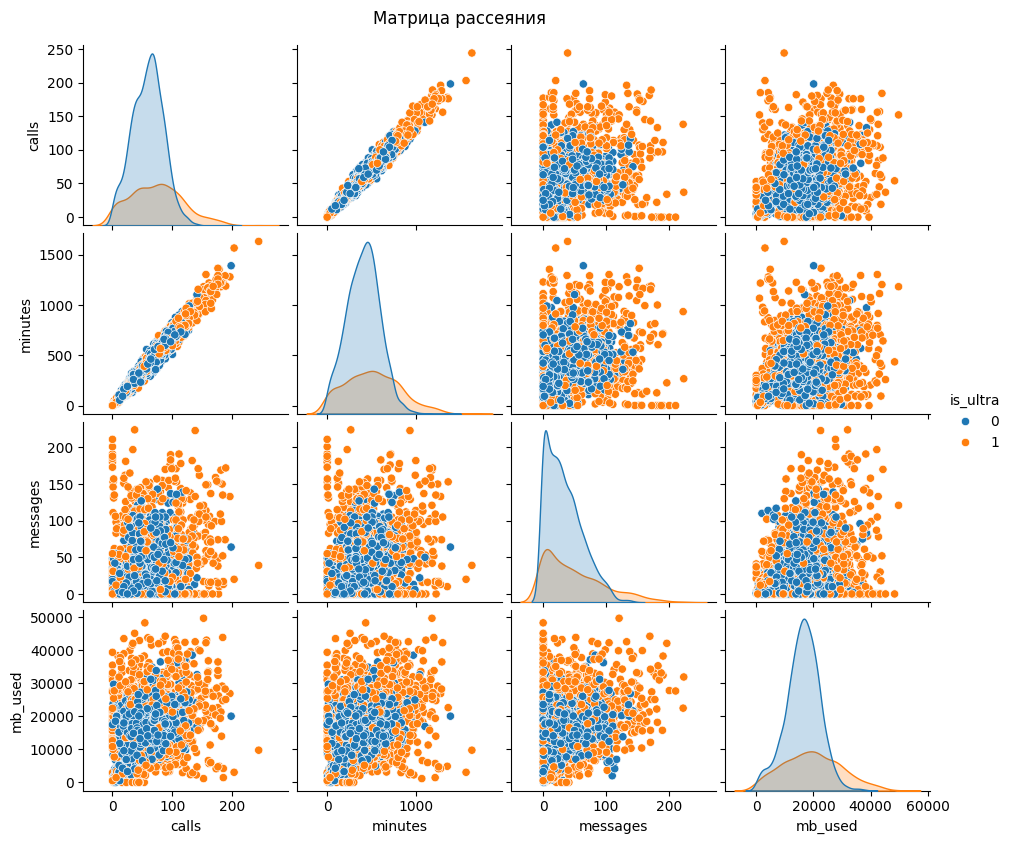

In [11]:
sns.pairplot(data, hue='is_ultra', height=3).fig.set_size_inches(10,8);
plt.title('Матрица рассеяния', x=-1.3, y=4.2);

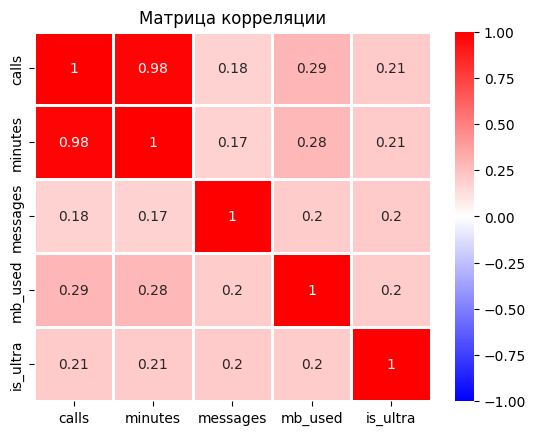

In [12]:
sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='bwr', linewidths=1);
plt.title('Матрица корреляции');

`calls` и `minutes` имеют схожие распределения и корреляцию `0.98`, что свидетельствует о наличии зависимости между ними. Подобные коллинеарные признаки усложняют подбор коэфициентов во время обучения моделей и могут привести к снижению эффективности обобщения данных, поэтому один из них нужно удалить. Оставим `minutes`, так как он несёт больше информации о том, сколько клиент тратит на услуги связи при выходе за рамки тарифа.

In [13]:
data = data.drop(['calls'], axis=1)

Последний шаг подготовки данных - разбиение датасета на обучающие признаки и целевой признак, затем на тренировочную, валидационную и тестовые выборки в соотношении 3:1:1. Тренировочная выборка будет использоваться для обучения моделей, валидационная для тестирования моделей во время обучения. Тестовую выборку отложем до самого последнего момента, когда лучшая модель уже будет выбрана. Такой сценарий наиболее приближён к реальному, когда тестовая выборка зачастую недоступна при разбработке моделей и истинную метрику можно получить уже после того, как модель будет выбрана и обучена.
Так же создадим отдельные датасеты с обучающими признаками, приведёнными к одному диапазону значений с помощью `StandardScaler()` для изучения влияния разброса значений признаков на обучение модели.  При этом обучать трансформер будем только на тренировочной выборке во избежание утечки.

In [14]:
X = data.drop(['is_ultra'], axis=1)
y = data['is_ultra']

In [15]:
X_train, X_test, y_train, y_test = (
    train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
)

In [16]:
X_train, X_val, y_train, y_val = (
    train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train)
)

In [17]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

Данные подготовлены. Приступим к исследованию моделей.

## Исследование моделей <a class="anchor" id="ис_мо"></a>

В данном исследовании будут рассмотрены `LogisiticRegression` и `RandomForestClassifier`. Начнём с регрессии, но сначала определимся с метрикой.

### Выбор метрики <a class="anchor" id="вы_ме"></a>

Изначально в данном проекте в качестве метрики была предложена `accuracy`, но в виду заметного дисбаланса классов принято решение использовать метрику `f1`.

### `LogisiticRegression` <a class="anchor" id="ло_ре"></a>

Рассмотрим следующие гиперпараметры:
* `class_weight`. В наших данных соотношение классов целевого признака 0.7 к 0.3, что указывает на дисбаланс классов, поэтому установим значение `balanced`.
* `C`. Отвечает за силу регуляризации. Меньшие значения задают более сильную регуляризацию, а высокие значения позволяют модели сильнее подстраиваться под обучающие данные и ведут к более сложным моделям. По умолчанию равно `1`. Выберем значения `0.001, 0.01, 0.1, 1, 10, 100`.
* `max_iter`. Это максимальное количество итераций, установленное для сходимости. По умолчанию имеет значение `100`. Для этого гиперпараметра установим диапазон `от 10 до 111 с шагом 20`.

Проведём обучение модели с разными комбинациями `C` и `max_iter`, выведем изменение `f1_score` в зависимости от гиперпараметров, посмотрим на скорость обучения модели и выведем набор гиперпараметров, обеспечивающий наибольшее значение `f1_score` и  затрачивающий наименьшее время на обучение.

In [18]:
params_LR = ['C', 'max_iter']
f1_LR = pd.DataFrame(
    columns=[*params_LR, 'f1_train', 'f1_val', 'fit_time']
)

for max_iter in range(10, 111, 20):
    for C in [0.001,0.01,0.1,1,10,100]:
        model_LR = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', C=C, max_iter=max_iter) 
        accumulator_df = fit_result(model_LR, params_LR, X_train, y_train, X_val, y_val)
        f1_LR = pd.concat([f1_LR, accumulator_df], ignore_index=True) 

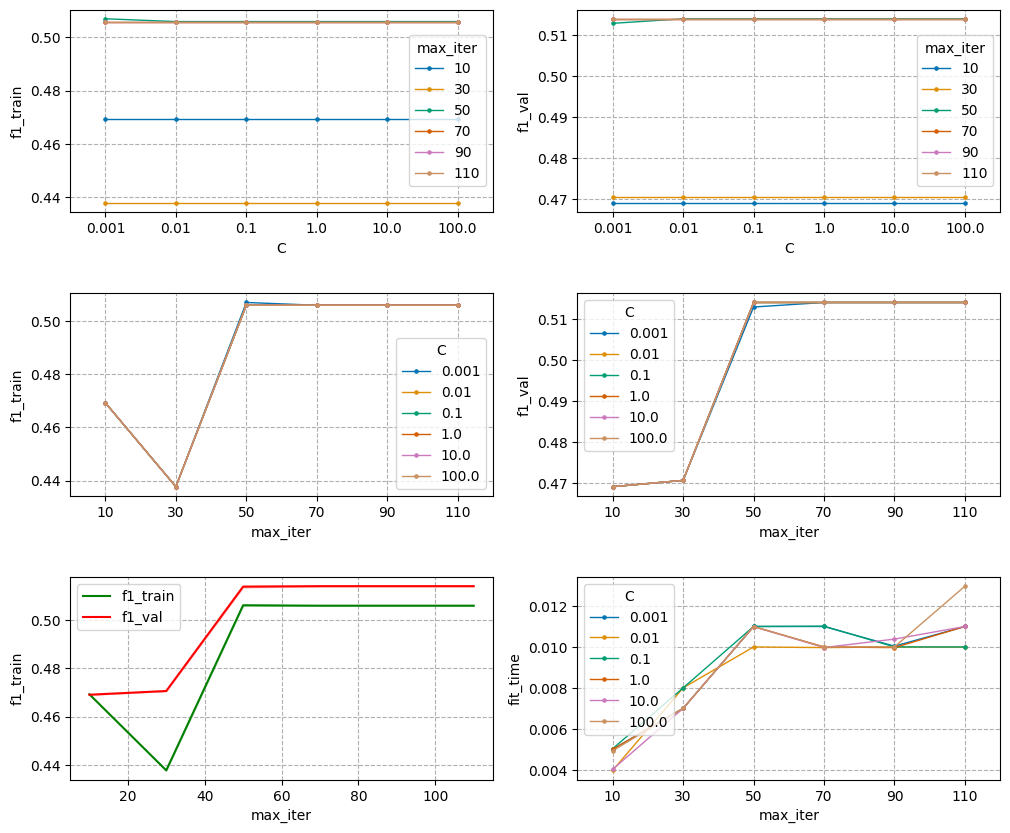

**Наилучший набор гиперпараметров:**

,C,max_iter,f1_train,f1_val,fit_time
35,100.0,110,0.50594,0.514039,0.012969


In [19]:
pair_plot(f1_LR, 'C', 'max_iter')

Можно сделать следующие выводы:
1. Сила регуляризации `C` не влияет на обучение модели на наших данных. Скорее всего это связано с тем, что признаки в признаковом пространстве распределены равномерно и их нельзя разделить линейной границей, как это видно на матрице рассеяния.
2. Довольно низкое значение `f1_score` и её слабая изменяемость в зависимости от `max_iter` (обучение выходит в "насыщение" уже при 50) так же говорит в пользу того, что данные плохо поддаются разделению линейной границей.
3. Время обучения растёт до **0.012** секунд с ростом `max_iter` до 50, затем так же выходит в "насыщение".

Выделим наилучший набор гиперпараметров **С = 0.001, max_iter = 110**, обеспечивший значение **f1_val 0.514 и fit_time 0.012**.

Посмотрим на коэффициенты модели. С их помощью можно понять, каким признакам модель отдаёт предпочтение и считает их более важными.

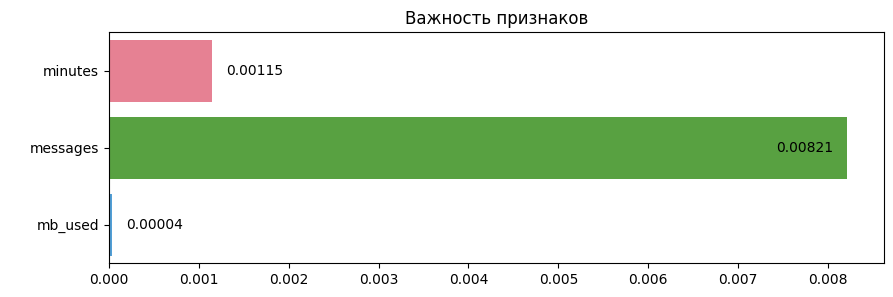

In [20]:
show_coef(X.columns, model_LR.coef_.flatten())

Коэффициент для `messages` сильно больше, а для `mb_used` почти незаметен в масштабе остальных. Это связано с порядком самих признаков. Повторим анализ с отмасштабированными данными.

In [21]:
params_LR = ['C', 'max_iter']
f1_LR_scaled = pd.DataFrame(
    columns=[*params_LR, 'f1_train', 'f1_val', 'fit_time']
)

for max_iter in range(10, 111, 20):
    for C in [0.001,0.01,0.1,1,10,100]:
        model_LR_scaled = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', C=C, max_iter=max_iter) 
        accumulator_df = fit_result(model_LR_scaled, params_LR, X_train_scaled, y_train, X_val_scaled, y_val)
        f1_LR_scaled = pd.concat([f1_LR_scaled, accumulator_df], ignore_index=True) 

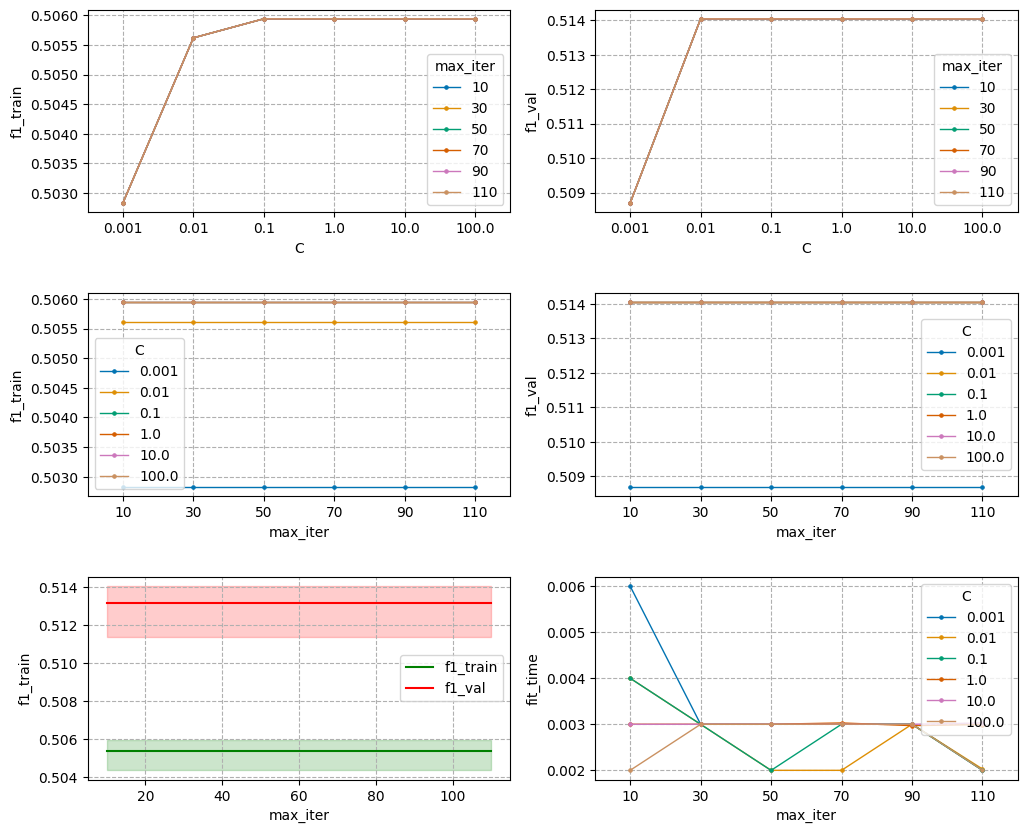

**Наилучший набор гиперпараметров:**

,C,max_iter,f1_train,f1_val,fit_time
1,0.01,10,0.505618,0.514039,0.004


In [22]:
pair_plot(f1_LR_scaled, 'C', 'max_iter')

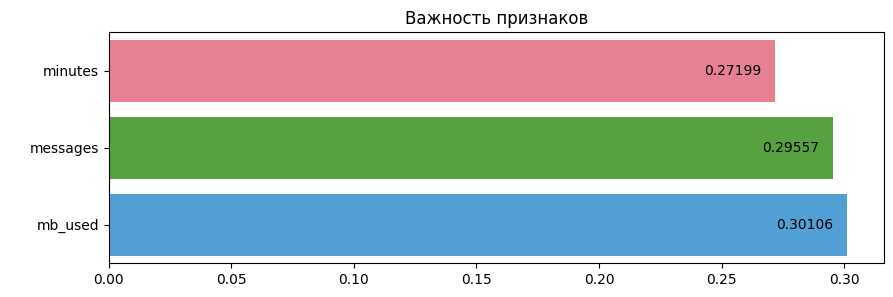

In [23]:
show_coef(X.columns, model_LR_scaled.coef_.flatten())

Получены аналогичные результаты, с небольшой разнцией:
* гиперпараметры ещё меньше влияют на качество модели;
* модель обучается быстрее и по времени, и по количеству перебранных параметров до получения максимальной метрики;
* коэффициенты признаков близки по значениям.
  
Масштабирование приводит скорости оптимизации коэффициентов в механизме градиентного спуска к одинаковым значениям, траектория изменения весов в пространстве функции потерь выпрямляется, что позволяет быстрее найти минимум функции потерь. Так же повышается интерпретируемость модели: `mb_used` оказывается немного важнее других признаков.

Приступим к `RandomForestClassifier`.

### `RandomForestClassifier` <a class="anchor" id="ра_фо"></a>

Для случайного леса будем подбирать следующие гиперпараметры:
* `class_weight` - уже знаком нам, так же выберем для него значение `balanced`.
* `n_estimators` - количество деревьев в лесу. Чем больше значение, тем сильнее модель подстраивается под обучающую выборку, растёт точность, но и вырастает вероятность переобучения. Установим диапазон `от 2 до 17 с шагом 3`.  
* `max_dept` - максимальная глубина дерева. Устанавливается для ограничения переобучения. Выберем значения `от 10 до 110 с шагом 20`.

Для "деревянных моделей" не нужно масштабировать данные, поэтому не будем рассматривать исследовать поведение модели на масштабированных данных.

In [24]:
params = ['max_depth', 'n_est']
f1_RFC = pd.DataFrame(
    columns=[*params, 'f1_train', 'f1_val', 'fit_time']
)

for max_depth in range(2, 15, 2):
    for n_est in range(10, 111, 20):
        model_RFC = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_estimators=n_est, max_depth=max_depth) 
        accumulator_df = fit_result(model_RFC, params, X_train, y_train, X_val, y_val)    
        f1_RFC = pd.concat([f1_RFC, accumulator_df], ignore_index=True) 

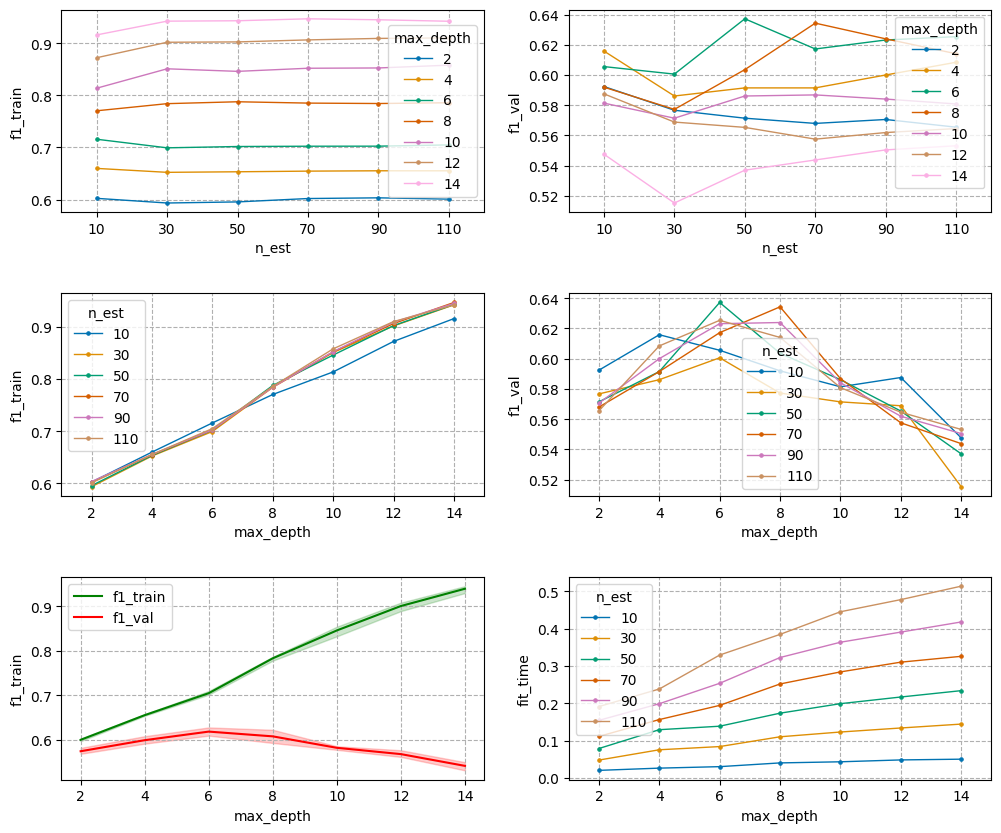

**Наилучший набор гиперпараметров:**

,max_depth,n_est,f1_train,f1_val,fit_time
14,6,50,0.701787,0.637168,0.138315


In [25]:
pair_plot(f1_RFC, 'n_est', 'max_depth')

У `RandomForestClassifier` можно выделить следующие закономерности:
1. `n_estimators` не сильно влияет на метрику при обучении, но оказывают влияение на метрику при валидации. Оптимальные значения находятся около **50**.
2. `max_depth` наоборот: с его увеличением метрика на тренировочной выборке линейно растёт. Но метрика на валидации сначала растёт, а после **6** начинает резко падать - это признак переобучения.
3. На время обучения влияют как `n_estimators`, так и `max_depth`. Не смотря на то, что время обучения модели с одним набором гиперпараметров всё ещё меньше секунды, при росте выборки данных фактор времени обучения будет вносить бо'льший вклад в подбор гиперпараметров.

Выделим наилучший набор гиперпараметров: **n_estimators 50, max_depth 6**, обеспечивающий значение **f1_val 0.637 и fit_time 0.133**.

Оценим важность признаков.

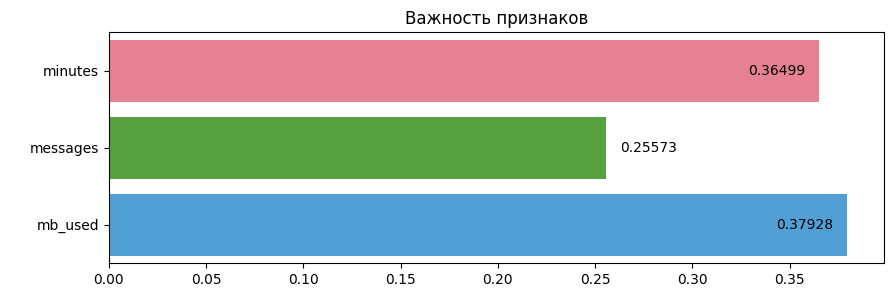

In [26]:
show_coef(X.columns, model_RFC.feature_importances_)

`mb_used` так же оказался наиболее важным, однако важность `messages` в случайном лесе не так велика.

Теперь нужно сравнить работу наших моделей с простым классификатором.

### `DummyClassifier` <a class="anchor" id="да_кл"></a>

In [27]:
model_DUMMY = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
model_DUMMY.fit(X_train, y_train)
predict_DUMMY = model_DUMMY.predict(X_val)
display(Markdown(f'f1_score Dummy классификатора: **{f1_score(predict_DUMMY, y_val).round(4)}**'))

f1_score Dummy классификатора: **0.3029**

Метрики наших моделей заметно лучше. Это говорит о том, что наши модели действительно пытаются найти закономерности в данных и у них это получается в некоторой степени.

### Тестирование лучшей модели <a class="anchor" id="те_лу"></a>

В ходе исследования наилучшие результаты показал `RandomForestClassifier` с гиперпараметрами `n_estimators=50` и `max_depth=6`. Обучим модель с такими гиперпараметрами и получим метрику на тестовой выборке.

In [28]:
model_best = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_estimators=50, max_depth=6) 
model_best.fit(X_train, y_train)
predict_best = model_best.predict(X_test)
display(Markdown(f'f1_score лучшей модели на тестовой выборке: **{f1_score(predict_best, y_test).round(4)}**'))

f1_score лучшей модели на тестовой выборке: **0.6443**

В рамках данного проекта такой результат можно считать успехом.

## Выводы <a class="anchor" id="вы"></a>

В данном проекте рассмотрены классификаторы `LogisiticRegression` и `RandomForestClassifier`. На этапе предобработки данные изучены на матрицах рассеяния и корреляции. Выявлен дисбаланс классов, удалён один из коллинеарных столбцов. Данные разбиты на тренировочную, валидационную и тестовую выборки с применением стратификации. Создан отдельный датасет с масштабированными признаками. В качестве метрики выбрана `f1` из-за дисбаланса классов. Реализован подобор гиперпараметров, проведён анализ влияния гиперпараметров на `f1_score` и время обучение. Рассмотрена важность признаков для обоих классификаторов. Моделей сравнены с простым классификатором и показали выше значения метрики. Выбрана и протестирована лучшая модель.

Можно выделить следующие закономерности:

Для `LogisiticRegression`:
1. Данные, на которых обучалась модель, оказались слишком перемешанны в пространстве признаков и модель не смогла их достаточно хорошо разделить, показав `f1_score` меньше **0.52** даже на тренировочной выборке.
2. Ввиду п.1 не удалось подробно исследовать влияние гиперпараметров на обучение модели. Видно лишь небольшое улучшение метрики с увеличением `max_iter`, но уже при `max_iter=50` метрика выходит в "насыщение".
3. Обучение модели на масштабированных данных не дало прироста к метрике, но модель стала обучаться быстрее, её коэффициенты стали интерпретируемы.


Для `RandomForestClassifier`:
1. С увеличением `max_depth` растёт метрика на тренировочной и валидационной выборках, однако после `max_depth=6` метрика на валидационной выборке снижается, наступает переобучение.
2. `n_estimators` не так сильно влияет на метрику, его влияение более хаотично.
3. С увеличением обоих параметров растёт время обучения модели.



Лучшей моделью признан `RandomForestClassifier` с гиперпараметрами `class_weight='balanced`,  `n_estimators=50`,  `max_depth=6` и `f1_score` **0.6443**.